# Spatial autocorrelation

(material taken from https://mgimond.github.io/Spatial/)


Suppose we have a collection of points on the earth's surface, and each point has a (numerical) feature value. We may ask the question: 

**Is the distribution of feature values random, or is there spatial structure?**

Technically, this amounts to the question whether the **spatial autocorrelation** is 0.


### Temporal autocorrelation

<img src=_img/Acf_new.svg width=500>
(image from Wikipedia)

<img src=_img/Random_maps.png>

**Moran's I** is a test statistic to test for spatial autocorrelation.

Let $N$ be the number of points and $w_{ij}$ the *weight* (strength of influence) between points $i$ and $j$. $w_{ii} =0$ for all $i$. 

$$
\begin{aligned}
I &= \frac{N}{W} \frac{\sum_{i,j} w_{ij}(x_i-\overline{x})(x_j-\overline{x}}{\sum_i(x_i-\overline{x})^2}
W &= \sum_{ij} w_{ij}\\
\overline x &= \frac{\sum_i x_i}{N}
\end{aligned}
$$

$I$ ranges from $-1$ to $1$. The expected value in the absence of spatial autocorrelation is 
$$
\frac{-1}{N-1}
$$

In [1]:
library(sf)
library(tidyverse)
library(tmap)
library(spdep)

Linking to GEOS 3.9.0, GDAL 3.2.2, PROJ 7.2.1; sf_use_s2() is TRUE

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 methods overwritten by 'stars':
  method             from
  st_bbox.SpatRaster sf  
  st_crs.SpatRaster  sf  

Loading required package: sp

Loading required package: spData



In [2]:
load(url("https://github.com/mgimond/Spatial/raw/main/Data/moransI.RData"))


In [3]:
st_as_sf(s1)

Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



,NAME,Income,NoSchool,NoSchoolSE,IncomeSE,geometry
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<MULTIPOLYGON [m]>
0,Aroostook,21024,0.01338720,0.001406960,250.909,MULTIPOLYGON (((513821.1 51...
1,Somerset,21025,0.00521153,0.001150020,390.909,MULTIPOLYGON (((379071.8 50...
2,Piscataquis,21292,0.00633830,0.002128960,724.242,MULTIPOLYGON (((445039.5 51...
3,Penobscot,23307,0.00684534,0.001025450,242.424,MULTIPOLYGON (((472271.3 49...
4,Washington,20015,0.00478188,0.000966036,327.273,MULTIPOLYGON (((645446.5 49...
5,Franklin,21744,0.00508507,0.001641740,530.909,MULTIPOLYGON (((355457.9 50...
6,Oxford,21885,0.00700822,0.001318160,536.970,MULTIPOLYGON (((339726.8 49...
7,Waldo,23020,0.00498141,0.000918837,450.909,MULTIPOLYGON (((466941.8 49...
8,Kennebec,25652,0.00570358,0.000917087,360.000,MULTIPOLYGON (((410590 4926...


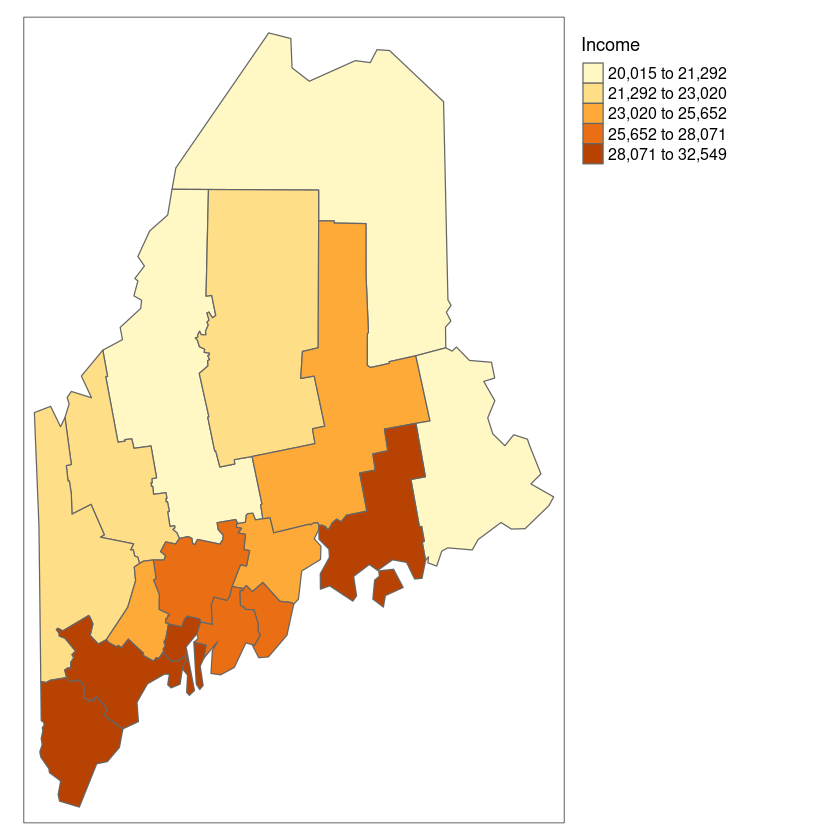

In [4]:
library(tmap)
tm_shape(s1) + tm_polygons(style="quantile", col = "Income") +
  tm_legend(outside = TRUE, text.size = .8) 

First we create a neighborhood matrix.

In [5]:
nb <- poly2nb(s1, queen=TRUE)
nb

Neighbour list object:
Number of regions: 16 
Number of nonzero links: 66 
Percentage nonzero weights: 25.78125 
Average number of links: 4.125 

In [6]:
nb[[1]]


[1] 2 3 4 5

In [7]:
s1$NAME[1]

[1] Aroostook
16 Levels: Androscoggin Aroostook Cumberland Franklin Hancock Kennebec ... York

In [8]:
s1$NAME[c(2,3,4,5)]

[1] Somerset    Piscataquis Penobscot   Washington 
16 Levels: Androscoggin Aroostook Cumberland Franklin Hancock Kennebec ... York

Next we assign weights to the edges of the neighborhood graph. For simplicity's sake, we assume equal weight for each neighbor.

In [9]:
lw <- nb2listw(nb, style="W", zero.policy=TRUE)

In [10]:
lw$weights[1]

[[1]]
[1] 0.25 0.25 0.25 0.25

Then we compute the weighted average of the incomes of neighboring counties for each county.

In [11]:
Inc.lag <- lag.listw(lw, s1$Income)

In [12]:
Inc.lag

[1] 21409.75 22673.17 21785.33 22407.83 24134.00 23207.50 26764.25 25505.83
 [9] 24336.33 25990.40 22114.00 25429.50 25983.75 25692.75 27577.00 27217.00

In [13]:
st_as_sf(s1) %>%
    st_drop_geometry() %>%
    select(NAME, Income) %>%
    mutate(Inc.lag = Inc.lag)

,NAME,Income,Inc.lag
,<fct>,<int>,<dbl>
0,Aroostook,21024,21409.75
1,Somerset,21025,22673.17
2,Piscataquis,21292,21785.33
3,Penobscot,23307,22407.83
4,Washington,20015,24134.00
5,Franklin,21744,23207.50
6,Oxford,21885,26764.25
7,Waldo,23020,25505.83
8,Kennebec,25652,24336.33


Doing some exploratory data analysis:

`geom_smooth()` using formula 'y ~ x'



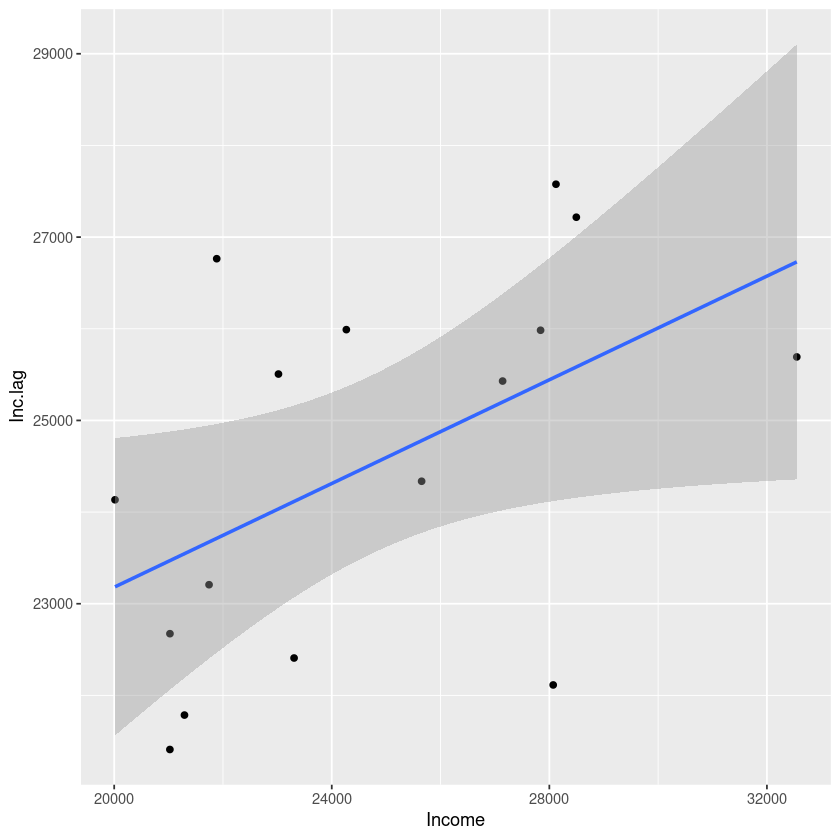

In [14]:
st_as_sf(s1) %>%
    st_drop_geometry() %>%
    select(NAME, Income) %>%
    mutate(Inc.lag = Inc.lag) %>%
    ggplot() +
    geom_point(aes(x=Income, y=Inc.lag)) +
    geom_smooth(aes(x=Income, y=Inc.lag), method=lm)

The slope of the regression line is Moran's I.

In [15]:
M <- lm(Inc.lag ~ s1$Income)
coef(M)[2]

s1$Income 
0.2828111

To assess significance, we can the a random permutation test.

In [16]:
n <- 599L   # Define the number of simulations
I.r <- vector(length=n)  # Create an empty vector

for (i in 1:n){
  # Randomly shuffle income values
  x <- sample(s1$Income, replace=FALSE)
  # Compute new set of lagged values
  x.lag <- lag.listw(lw, x)
  # Compute the regression slope and store its value
  M.r    <- lm(x.lag ~ x)
  I.r[i] <- coef(M.r)[2]
}

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



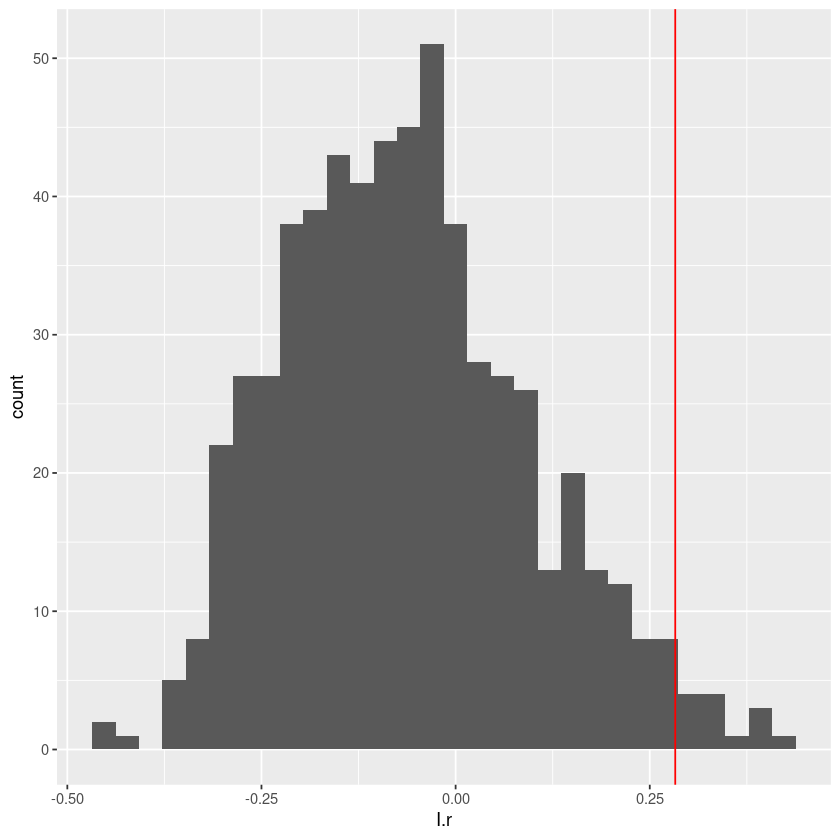

In [17]:
data.frame(I.r = I.r) %>%
    ggplot() +
    geom_histogram(aes(x=I.r)) +
    geom_vline(xintercept=coef(M)[2], col='red')

Pseudo-$p$-value:

In [18]:
mean(I.r > coef(M)[2])

[1] 0.02337229

The Moran test does not use permutations but computes the $p$-value analytically.

In [21]:
moran.test(s1$Income,lw)


	Moran I test under randomisation

data:  s1$Income  
weights: lw    

Moran I statistic standard deviate = 2.2472, p-value = 0.01231
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
       0.28281108       -0.06666667        0.02418480 


There is also a version of Moran's I test using simulations:


In [22]:
MC<- moran.mc(s1$Income, lw, nsim=599)

# View results (including p-value)
MC


	Monte-Carlo simulation of Moran I

data:  s1$Income 
weights: lw  
number of simulations + 1: 600 

statistic = 0.28281, observed rank = 590, p-value = 0.01667
alternative hypothesis: greater


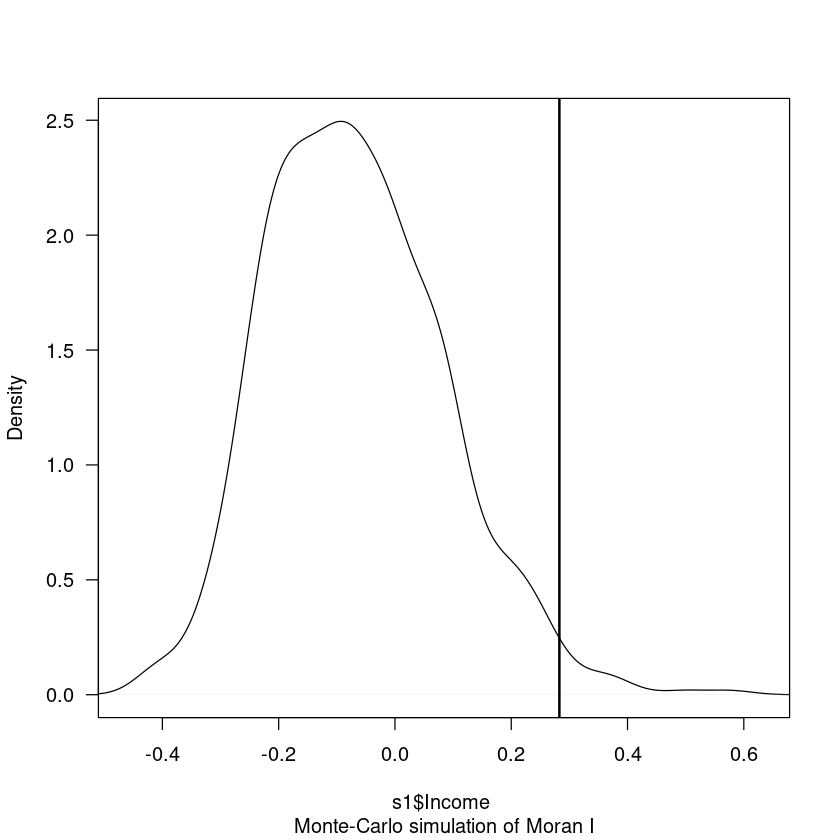

In [23]:
# Plot the distribution (note that this is a density plot instead of a histogram)
plot(MC, main="", las=1)